In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
from sklearn import metrics
import random

In [17]:

# Define the dataset directory path
dataset_dir = r"C:\Users\hp\OneDrive\Desktop\drowness of eye detection\dataset"

# List files in the dataset directory
files_in_dataset = os.listdir(dataset_dir)
print("Files in dataset directory:")
for file_name in files_in_dataset:
    print(file_name)




Files in dataset directory:
Drowsy
Non Drowsy


In [18]:
class_names = []
features = []
labels = []
image_size = (224, 224)

for path, subdirs, files in os.walk(dataset_dir):
    num_files = len(files)
    num_to_select = int(num_files * 0.1)
    selected_files = random.sample(files, num_to_select)
        
    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("png"):
            image_read = cv2.imread(img_path)
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0
            
            path_parts = path.split('/')
            label = path_parts[-1]
            
            if label not in class_names:
                class_names.append(label)
            
            features.append(image_normalized)
            index = class_names.index(label)
            labels.append(index)
                
features = np.asarray(features)
labels = np.asarray(labels)

0it [00:00, ?it/s]
100%|██████████| 894/894 [00:10<00:00, 84.51it/s] 


In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [20]:
del features
del labels

In [21]:
# Hyperparameter
learning_rate = 0.001
epochs = 100
batch_size = 16

In [22]:
# Define the model
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



9406464/9406464 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

In [23]:
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint, csv_logger, early_stopping],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

print(f"Training Time : {end_time - start_time}")

Epoch 1/100


108/108 [==============================] - ETA: 0s - loss: 3.0987 - accuracy: 0.9419

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 49s 417ms/step - loss: 3.0987 - accuracy: 0.9419 - val_loss: 0.3103 - val_accuracy: 0.9919
Epoch 2/100
108/108 [==============================] - 42s 392ms/step - loss: 0.0619 - accuracy: 0.9924 - val_loss: 0.6431 - val_accuracy: 0.9810
Epoch 3/100
108/108 [==============================] - 43s 401ms/step - loss: 0.0248 - accuracy: 0.9977 - val_loss: 0.4897 - val_accuracy: 0.9919
Epoch 4/100
108/108 [==============================] - 41s 383ms/step - loss: 0.0315 - accuracy: 0.9977 - val_loss: 0.6492 - val_accuracy: 0.9864
Epoch 5/100
108/108 [==============================] - 41s 380ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.4615 - val_accuracy: 0.9919
Epoch 6/100
108/108 [==============================] - 41s 375ms/step - loss: 8.6490e-07 - accuracy: 1.0000 - val_loss: 0.4631 - val_accuracy: 0.9919
Epoch 7/100
108/108 [==============================] - 41s 383ms/step - loss: 3.4971e-07 - accuracy: 1.0000 - val_loss: 0.4637 - val

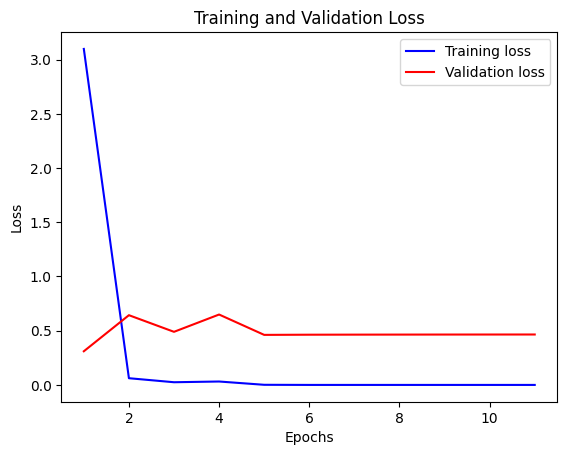

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join('loss.png'))
plt.show()

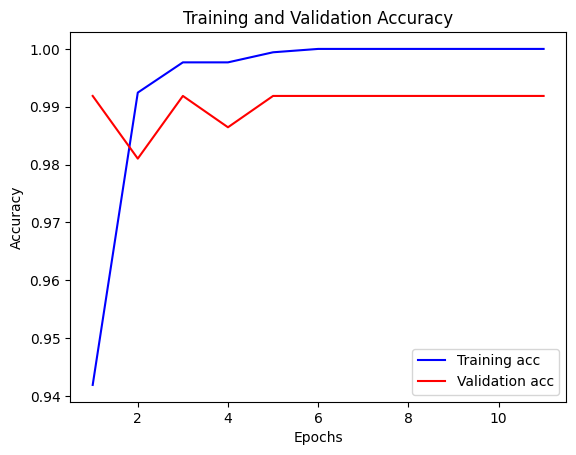

In [25]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join( 'accuracy.png'))
plt.show()

In [28]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

with open(os.path.join('classification_report.txt'), 'w') as file:
    file.write(classification_rep)

12/12 [==============================] - 6s 309ms/step
Classification Report:
                                                                            precision    recall  f1-score   support

    C:\Users\hp\OneDrive\Desktop\drowness of eye detection\dataset\Drowsy     0.9917    1.0000    0.9958       238
C:\Users\hp\OneDrive\Desktop\drowness of eye detection\dataset\Non Drowsy     1.0000    0.9847    0.9923       131

                                                                 accuracy                         0.9946       369
                                                                macro avg     0.9958    0.9924    0.9941       369
                                                             weighted avg     0.9946    0.9946    0.9946       369



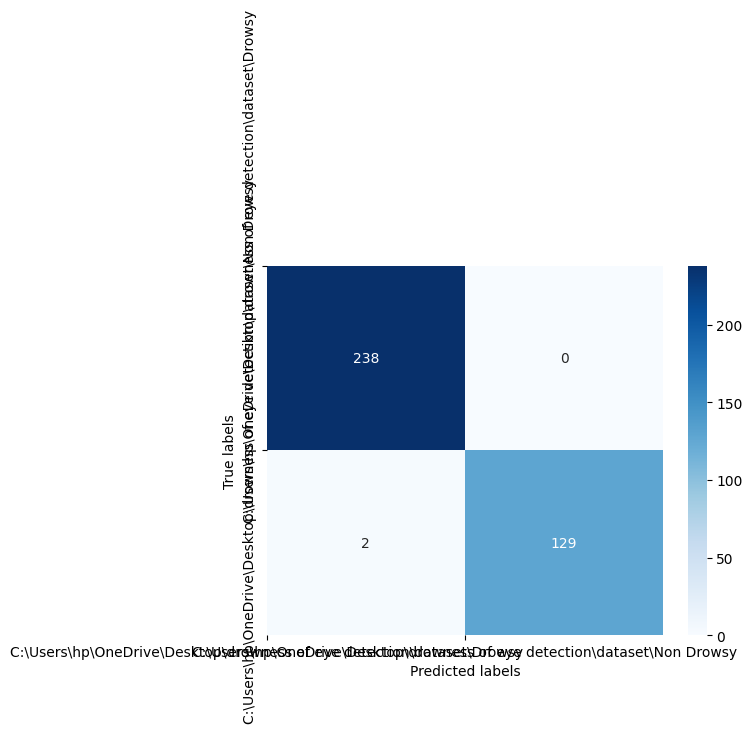

In [29]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join('confusion matrix.png'))
plt.show()